In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from scipy.stats import randint
from sklearn import metrics


In [2]:
df = pd.read_csv('C:\\Users\Prateek\PycharmProjects\pythonProject\Airlines.csv')
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [3]:
# Delete id column
df = df.drop(columns = ['id'])

In [4]:
# Bring only the nuemric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_column_names = df.select_dtypes(include=numerics).columns
print(numeric_column_names, '\n')

# Bring only the object columns (strings)
objects = 'object'
object_column_names = df.select_dtypes(include=objects).columns
print(object_column_names, '\n')

Index(['Flight', 'DayOfWeek', 'Time', 'Length', 'Delay'], dtype='object') 

Index(['Airline', 'AirportFrom', 'AirportTo'], dtype='object') 



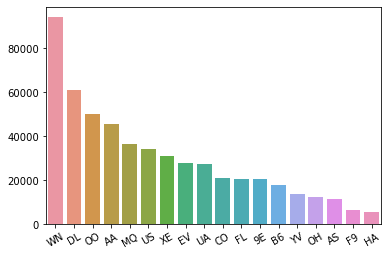

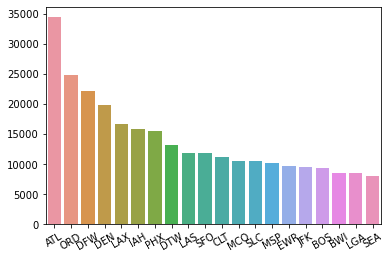

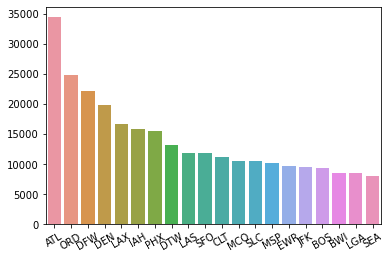

In [5]:
for column in object_column_names:
    value_counts_column =  df[column].value_counts()
    if value_counts_column.shape[0] > 20:
        value_counts_column = value_counts_column.sort_values(ascending = False)
        value_counts_column = value_counts_column[:20]
    ax = sns.barplot(y=value_counts_column.values, x=value_counts_column.index)
    ax = ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.show()

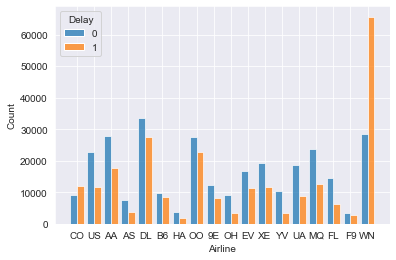

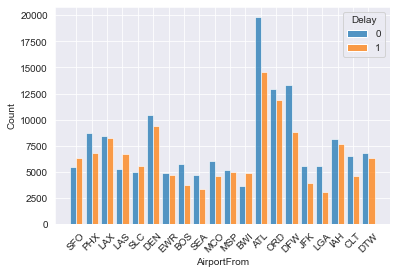

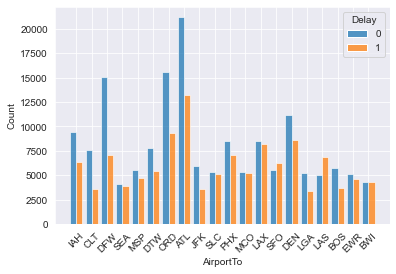

In [10]:
for column in object_column_names:
    value_counts_column =  df[column].value_counts()
    if value_counts_column.shape[0] > 20:
        value_counts_column = value_counts_column.sort_values(ascending = False)
        value_counts_column = value_counts_column[:20]
        df_aux = df[df[column].isin(value_counts_column[:20].index)]
        ax = sns.histplot(data=df_aux, x=column, hue='Delay',  multiple="dodge", shrink=.8)
        plt.xticks(rotation=45)
        plt.show()
    else:
        ax = sns.histplot(data=df, x=column, hue='Delay',  multiple="dodge", shrink=.8)
        plt.show()

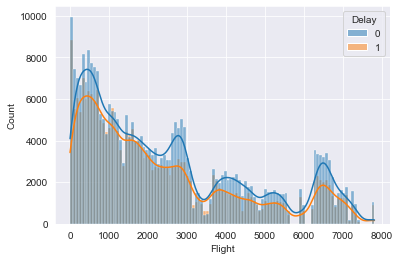

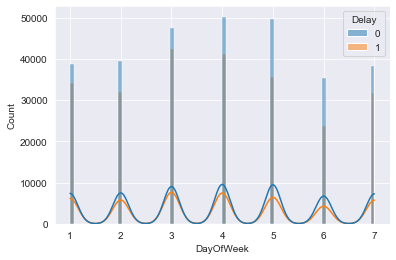

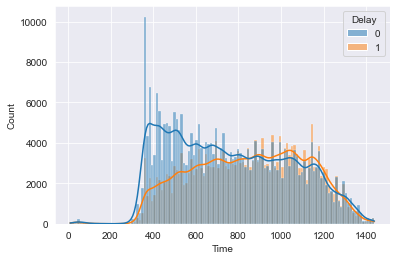

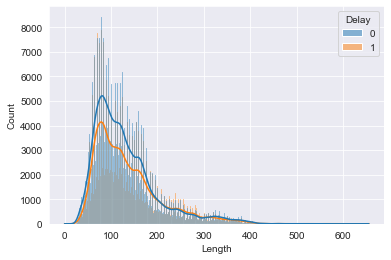

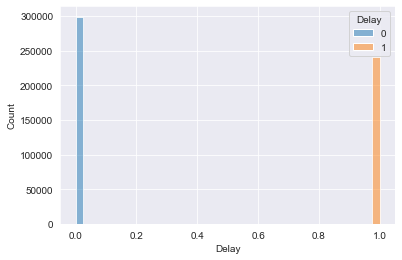

In [11]:
for column in numeric_column_names:
    ax = sns.histplot(data=df, x=column, hue='Delay', kde=True)
    plt.show()

In [13]:
feature = df.drop(columns=['Delay','AirportTo', 'AirportFrom'])
target = df['Delay']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature , target,
                                                    shuffle = True,
                                                    test_size=0.2,
                                                    random_state=1)

In [17]:
from sklearn.preprocessing import OrdinalEncoder

# Function to create the new columns with Oridinal Encoding
def ordinal_encoding(X_train, X_test, columns):

    # Create the encoder
    ord_enc = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=-1)
    ord_enc.fit(X_train[columns])

    # Transfrom both train and test datasets (separately)
    new_columns_train = ord_enc.transform(X_train[columns])
    new_columns_test = ord_enc.transform(X_test[columns])

    # Creating the name of the columns, being the same name as the original but with a _num at the end
    column_num_names = columns + '_num'

    # Creating a dataframe for the new columns
    new_columns_train = pd.DataFrame(new_columns_train, columns = column_num_names, index = X_train.index)
    new_columns_test = pd.DataFrame(new_columns_test, columns = column_num_names, index = X_test.index)

    # Concating the new columns to the original datasets
    X_train = pd.concat([X_train, new_columns_train], axis=1)
    X_test = pd.concat([X_test, new_columns_test], axis=1)

    return X_train, X_test

In [18]:
# Delete the columns AirportTo and AirportFrom, because we're going to use only the columns Airline for Categorical column
object_column_names = object_column_names.drop(['AirportTo', 'AirportFrom'],errors = 'ignore')
X_train, X_test = ordinal_encoding(X_train, X_test, object_column_names)

# Drop the columns we will not use
X_train = X_train.drop(columns = object_column_names)
X_test = X_test.drop(columns = object_column_names)

In [20]:
# Function to evaluate easily multiple models
def evaluate_model(model, x_test, y_test):

    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa,
            'cm': cm}

# Show results from evaluate_model
def print_metrics(eval):
    # Print result
    print('Accuracy:', (eval['acc'] * 100).round(2), '%')
    print('Precision:', (eval['prec']* 100).round(2), '%')
    print('Recall:', (eval['rec']* 100).round(2), '%')
    print('F1 Score:', (eval['f1'] * 100).round(2), '%')
    print('Cohens Kappa Score:', (eval['kappa'] * 100).round(2), '%')
    print('Confusion Matrix:\n', eval['cm'])

In [21]:
# Show results from cross_validation()
def print_results(results):
    mean = results['test_score'].mean()
    std = results['test_score'].std()
    print('Accuracy mean %.2f' % (mean * 100))
    print('Accuracy interval %.2f %.2f' % ((mean - 2 * std) * 100, (mean + 2 *std) * 100))

In [22]:
from sklearn.preprocessing import StandardScaler

# Function to scale the dataset
def scaling(X_train, X_test):
    scaler_feature = StandardScaler()
    scaler_feature.fit(X_train)

    X_train_scaled = scaler_feature.transform(X_train)
    X_test_scaled = scaler_feature.transform(X_test)
    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = scaling(X_train, X_test)

In [35]:
# Function to train and test the models and show the results in a organized way
def run_classification(model, X_train, X_test, y_train, y_test):
    cv = KFold(n_splits=5, shuffle=True)
    results = cross_validate(model, X_train, y_train, cv = cv)

    print_results(results)
    print('------------------')

    # Evaluate Model
    model.fit(X_train, y_train)
    dtc_eval = evaluate_model(model, X_test, y_test)
    print_metrics(dtc_eval)

In [36]:
from sklearn.dummy import DummyClassifier

dummy_stratified = DummyClassifier(strategy='stratified')
run_classification(dummy_stratified, X_train_scaled, X_test_scaled, y_train, y_test)

Accuracy mean 50.59
Accuracy interval 50.33 50.86
------------------
Accuracy: 50.53 %
Precision: 44.54 %
Recall: 44.54 %
F1 Score: 44.54 %
Cohens Kappa Score: -0.11 %
Confusion Matrix:
 [[33073 26686]
 [26685 21433]]


In [37]:
from sklearn.tree import DecisionTreeClassifier

descision_tree = DecisionTreeClassifier()
run_classification(descision_tree, X_train_scaled, X_test_scaled, y_train, y_test)

Accuracy mean 60.65
Accuracy interval 60.42 60.88
------------------
Accuracy: 60.69 %
Precision: 57.23 %
Recall: 47.02 %
F1 Score: 51.62 %
Cohens Kappa Score: 19.05 %
Confusion Matrix:
 [[42848 16911]
 [25494 22624]]


In [38]:
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()
run_classification(gaussian, X_train_scaled, X_test_scaled, y_train, y_test)

Accuracy mean 58.57
Accuracy interval 58.20 58.94
------------------
Accuracy: 58.61 %
Precision: 55.34 %
Recall: 37.31 %
F1 Score: 44.57 %
Cohens Kappa Score: 13.49 %
Confusion Matrix:
 [[45271 14488]
 [30167 17951]]


In [39]:
from sklearn.neighbors import KNeighborsClassifier

k_neighbors = KNeighborsClassifier()
run_classification(k_neighbors, X_train_scaled, X_test_scaled, y_train, y_test)

Accuracy mean 61.29
Accuracy interval 61.07 61.51
------------------
Accuracy: 61.39 %
Precision: 57.32 %
Recall: 52.61 %
F1 Score: 54.86 %
Cohens Kappa Score: 21.24 %
Confusion Matrix:
 [[40908 18851]
 [22802 25316]]
